In [1]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
import import_ipynb
from Dataset import HahaDataset
from ClassificationCollator import Gpt2ClassificationCollator

importing Jupyter notebook from Dataset.ipynb
importing Jupyter notebook from ClassificationCollator.ipynb


/opt/anaconda3/lib/python3.7/site-packages/nbformat/notebooknode.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [2]:
set_seed(123)
epochs = 4
batch_size = 32
max_length = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'gpt2'
labels_ids = {0: 0, 1: 1}
n_labels = len(labels_ids)

In [3]:
def train(dataloader, optimizer_, scheduler_, device_):

    global model

    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    for batch in tqdm(dataloader, total=len(dataloader)):

        true_labels += batch['labels'].numpy().flatten().tolist()

        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        model.zero_grad()

        outputs = model(**batch)

        loss, logits = outputs[:2]

        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        
        scheduler.step()

        logits = logits.detach().cpu().numpy()

        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    avg_epoch_loss = total_loss / len(dataloader)
    
    return true_labels, predictions_labels, avg_epoch_loss

In [12]:
def validation(dataloader, device_):
 
   
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):

       
        # true_labels += batch['labels'].numpy().flatten().tolist()

        print(batch,batch.items())
      
        batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

           
            outputs = model(**batch)

        
            loss, logits = outputs[:2]

            logits = logits.detach().cpu().numpy()

            total_loss += loss.item()

            # get predicitons to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # update list
            predictions_labels += predict_content

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediciton for future evaluations.
    return predictions_labels, avg_epoch_loss

In [5]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cpu`


In [6]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = HahaDataset('./../Data/train_data/train.csv', use_tokenizer=tokenizer,task ="is_humor")
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  HahaDataset('./../Data/test_data/public_test.csv', use_tokenizer=tokenizer,task ="test")
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...
Created `train_dataset` with 8000 examples!
Created `train_dataloader` with 250 batches!

Dealing with Validation...
Created `valid_dataset` with 1000 examples!
Created `eval_dataloader` with 32 batches!


Epoch



Training on batches...



  train_loss: 0.61471 - train_acc: 0.70850


Training on batches...



  train_loss: 0.36754 - train_acc: 0.83562


Training on batches...



  train_loss: 0.30183 - train_acc: 0.86925


Training on batches...



  train_loss: 0.27359 - train_acc: 0.88087




/opt/anaconda3/lib/python3.7/site-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


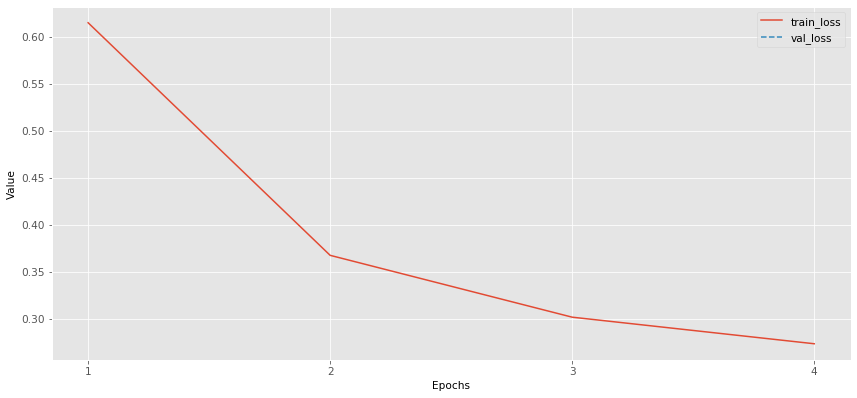

/opt/anaconda3/lib/python3.7/site-packages/ml_things/plot_functions.py:410: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  DeprecationWarning)


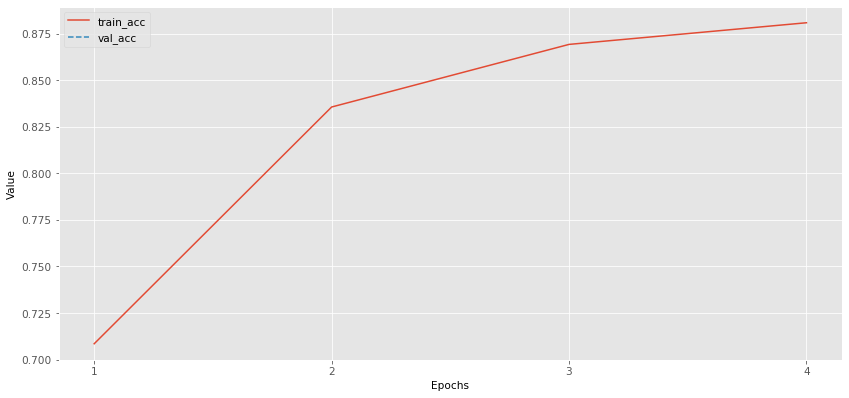

In [7]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print("  train_loss: %.5f - train_acc: %.5f"%(train_loss, train_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
#     all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
#     all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

In [ ]:
# Get prediction form model on validation data. 
print('Validation on batches...')
valid_predict, val_loss = validation(valid_dataloader, device)
output_list = []
for pred in valid_predict:
    temp = {}
    temp['is_humor'] = pred
    output_list.append(temp)

out_df = pandas.DataFrame(output_list)
out_df.to_csv('submission_is_humor.csv', index_label='id')